# Bayesian Neural Networks para imagenes (BCNN)

## Cargue de datos y librerias

In [17]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import os
import time
import shutil
import pathlib
import itertools
# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image
from collections import defaultdict
import pandas as pd
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import cv2
import dash_bootstrap_components as dbc
import tensorflow as tf
import base64
from PIL import Image
import io
import requests
from io import StringIO,BytesIO
from skimage.filters import gaussian
from skimage import feature, img_as_ubyte, transform
from scipy.ndimage import gaussian_filter as gaussian
from tensorflow.keras.models import load_model
import tempfile
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.layers import DenseVariational, DenseReparameterization, DenseFlipout, Convolution2DFlipout, Convolution2DReparameterization
from tensorflow_probability.python.layers import DistributionLambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *
tf.compat.v1.enable_eager_execution()
import pandas as pd
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow_probability.python.layers import Convolution2DFlipout, DenseFlipout
from scipy.stats import shapiro
import plotly.express as px

In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.layers import DenseVariational, DenseReparameterization, DenseFlipout, Convolution2DFlipout, Convolution2DReparameterization
from tensorflow_probability.python.layers import DistributionLambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *
tf.compat.v1.enable_eager_execution()
import pandas as pd
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

In [11]:
# Cargar el conjunto de datos MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Mapeo de etiquetas a números
label_mapping = {0: 'cero', 1: 'uno', 2: 'dos', 3: 'tres', 4: 'cuatro', 5: 'cinco', 6: 'seis', 7: 'siete', 8: 'ocho', 9: 'nueve'}

## Cargue de modelos

Para optimizar el proceso de entrenamiento de los modelos, ya que consumia muchos recursos computacionales y de tiempo, se entrenaron en una maquina virtual y se guardaron en un archivo h5 y para que quedaran en la red se subio el archvivo a github para asi conectarnos a el

In [29]:
def load_model_from_github(url):
    response = requests.get(url)
    response.raise_for_status()  # Asegúrate de que la solicitud fue exitosa

    # Guardar en un archivo temporal
    with tempfile.NamedTemporaryFile(delete=False, suffix='.h5') as tmp:
        tmp.write(response.content)
        tmp.flush()  # Asegúrate de que todo el contenido se escriba en el archivo
        model = load_model(tmp.name)  # Cargar el modelo desde el archivo temporal

    return model

In [30]:
model_url = 'https://github.com/vesgac/Visualizaci-n/raw/main/modelo_cnn.h5'
pesos_url = 'https://github.com/vesgac/Visualizaci-n/raw/main/pesos_bcnn_weights.h5'

model_cnn = load_model_from_github(model_url)

In [7]:
def neg_log_likelihood_with_logits(y_true, y_pred):
    y_pred_dist = tfp.distributions.Categorical(logits=y_pred)
    return -tf.reduce_mean(y_pred_dist.log_prob(tf.argmax(y_true, axis=-1)))

def add_kl_weight(layer, train_size, w_value=1.0):
    w = layer.add_weight(name=layer.name+'/kl_loss_weight', shape=(),
                         initializer=tf.initializers.constant(w_value), trainable=False)
    layer.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return layer

def get_kernel_divergence_fn(train_size, w=1.0):
    """
    Get the kernel Kullback-Leibler divergence function

    # Arguments
        train_size (int): size of the training dataset for normalization
        w (float): weight to the function

    # Returns
        kernel_divergence_fn: kernel Kullback-Leibler divergence function
    """
    def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence
    return kernel_divergence_fn


In [8]:
model_in = Input(shape=(28, 28, 1))
model_in

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'input_1')>

### Cargue de arquitetura

In [9]:
def build_bayesian_bcnn_model(input_shape, train_size, n_class):
    model_in = Input(shape=input_shape)
    conv_1 = Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_1 = add_kl_weight(conv_1, train_size)
    x = conv_1(model_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv_2 = Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_2 = add_kl_weight(conv_2, train_size)
    x = conv_2(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    dense_1 = DenseFlipout(512, activation='relu',
                           kernel_divergence_fn=None)
    dense_1 = add_kl_weight(dense_1, train_size)
    x = dense_1(x)
    dense_2 = DenseFlipout(n_class, activation=None,
                           kernel_divergence_fn=None)
    dense_2 = add_kl_weight(dense_2, train_size)
    model_out = dense_2(x)  # logits
    model = Model(model_in, model_out)
    return model

el h5 no sirve mucho para las BCNN en cuestiones de que guarde el modelo, entonces al guardar los pesos definimos otra vez la arquitectura y el backend que hay detras.

In [13]:
n_class = 10
batch_size = 128
n_epochs = 20
lr = 1e-3

In [14]:
print('Loading MNIST dataset')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, n_class)
y_test = tf.keras.utils.to_categorical(y_test, n_class)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

Loading MNIST dataset
X_train.shape = (60000, 28, 28, 1)
y_train.shape = (60000, 10)
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


In [12]:
model_bcnn = build_bayesian_bcnn_model((28, 28, 1),60000, 10)
model_bcnn.compile(loss=neg_log_likelihood_with_logits, optimizer=Adam(learning_rate=1e-3), metrics=['acc'],
                   experimental_run_tf_function=False)
# Descargar el archivo de pesos
response = requests.get(pesos_url)

# Verificar si la descarga fue exitosa
if response.status_code == 200:
    # Guardar el contenido en un archivo local
    with open('pesos_bcnn_weights.h5', 'wb') as f:
        f.write(response.content)
    # Cargar los pesos en el modelo bcnn_model_mnist
    model_bcnn.load_weights('pesos_bcnn_weights.h5')

c:\miniconda\envs\imagenes_venv\lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
c:\miniconda\envs\imagenes_venv\lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


## Validacion del modelo

In [21]:
def fetch_csv_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Asegura que la respuesta sea exitosa
        data = response.content.decode('utf-8')
        df = pd.read_csv(StringIO(data))
        return df
    except requests.RequestException as e:
        print(f"Error al realizar la solicitud HTTP: {e}")
    except pd.errors.ParserError as e:
        print(f"Error al parsear el CSV: {e}")
    except Exception as e:
        print(f"Otro error: {e}")

url1 = 'https://github.com/vesgac/Visualizaci-n/raw/main/mnist_bcnn_history.csv'
history_bcnn = fetch_csv_from_url(url1)
url3 = 'https://github.com/vesgac/Visualizaci-n/raw/main/resultados_4.csv'
resultados = fetch_csv_from_url(url3)
        

def normalize_column_names(df, standard_names):
    mapping = {
        'acc': 'accuracy',
        'val_acc': 'val_accuracy',
        'loss': 'loss',  # Asumiendo que 'loss' ya está normalizado
        'val_loss': 'val_loss'  # Asumiendo que 'val_loss' ya está normalizado
    }
    # Usar 'standard_names' para garantizar que todos los nombres necesarios están presentes
    df = df.rename(columns=lambda x: mapping.get(x, x))
    missing_cols = set(standard_names) - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing expected columns: {missing_cols}")
    return df

standard_names = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
history_bcnn = normalize_column_names(history_bcnn, standard_names)

In [14]:
def create_accuracy_and_loss_plots(history_df):
    # Crear la figura para la precisión del modelo
    fig_accuracy = go.Figure()
    fig_accuracy.add_trace(go.Scatter(x=history_df.index, y=history_df['accuracy'], mode='lines+markers', name='Train Accuracy'))
    fig_accuracy.add_trace(go.Scatter(x=history_df.index, y=history_df['val_accuracy'], mode='lines+markers', name='Validation Accuracy'))
    fig_accuracy.update_layout(
        title='Model Accuracy Over Epochs',  # Título provisional
        xaxis_title='Epoch',
        yaxis_title='Accuracy',
        legend_title='Type',
        width=500  # Ancho apropiado para visualización lado a lado
    )

    # Crear la figura para la pérdida del modelo
    fig_loss = go.Figure()
    fig_loss.add_trace(go.Scatter(x=history_df.index, y=history_df['loss'], mode='lines+markers', name='Train Loss'))
    fig_loss.add_trace(go.Scatter(x=history_df.index, y=history_df['val_loss'], mode='lines+markers', name='Validation Loss'))
    fig_loss.update_layout(
        title='Model Loss Over Epochs',  # Título provisional
        xaxis_title='Epoch',
        yaxis_title='Loss',
        legend_title='Type',
        width=500  # Ancho apropiado para visualización lado a lado
    )

    return fig_accuracy, fig_loss

fig,fig2=create_accuracy_and_loss_plots(history_bcnn)
fig.show()
fig2.show()

Con estos graficos podemos validar que efectivamente si esta aprendiendo ya que podemos ver que la funcion de perdida esta bajando y a medida que aumentan las epocas el val_accuracy va subiendo

Text(0.5, 1.0, 'Confusion Matrix')

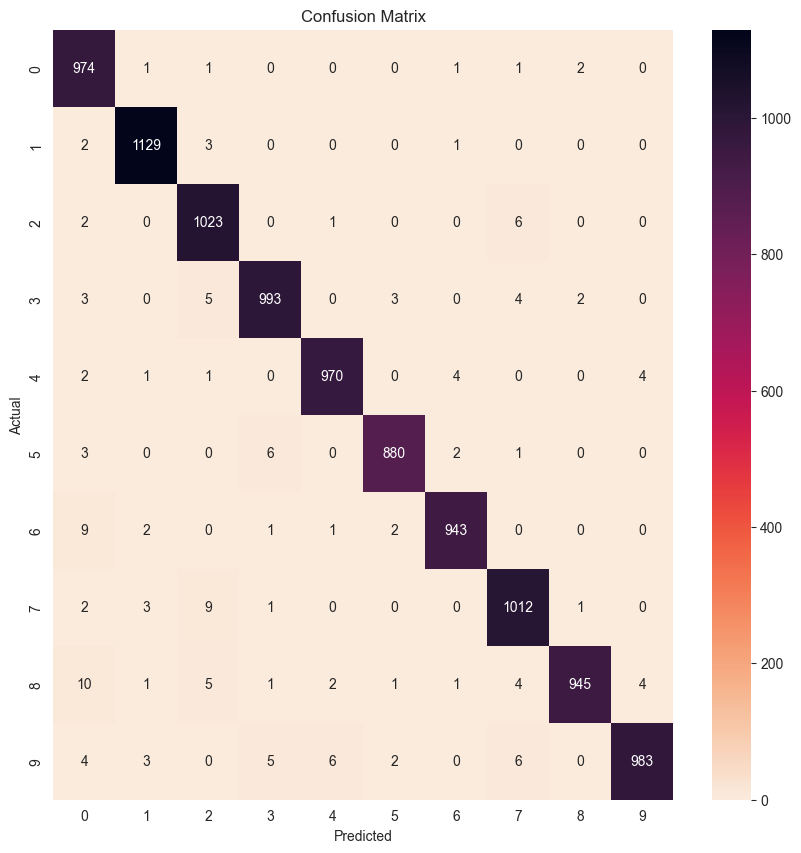

In [15]:
# Calcular la matriz de confusión
conf_mat = confusion_matrix(resultados["Test"],resultados["normal_bnn"])
# Visualiza la matriz de confusión usando Seaborn y Matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=[f'{i}' for i in range(10)],
                yticklabels=[f'{i}' for i in range(10)],
                cmap="rocket_r")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')


con esta matriz de confunsion viendo la matriz principal podemos ver que el modelo puede predecir bien nuestros datos, podemos ver que se puede confiar en el BCNN

In [16]:
def plot_multiclass_roc(y_test, y_pred, num_classes):
    # Binarizar las etiquetas en un formato one-hot
    y_test_binarized = label_binarize(y_test, classes=list(range(num_classes)))
    y_pred_binarized = label_binarize(y_pred, classes=list(range(num_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calcula la curva ROC y el área bajo la curva para cada clase
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Crea la figura de Plotly para la curva ROC
    fig = go.Figure()
    for i in range(num_classes):
        hover_text = f'Class {i} AUC = {roc_auc[i]:.2f}'
        fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', name=f'Class {i}',
                                 text=[hover_text] * len(fpr[i]), hoverinfo='text+x+y'))

    # Agregar línea de azar
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='navy', width=2, dash='dash'),
                             name='Chance', hoverinfo='none'))

    # Configuración del layout del gráfico
    fig.update_layout(
        title='Multiclass ROC Curve',
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        legend_title='Classes',
        xaxis=dict(scaleanchor="y", scaleratio=1),
        yaxis=dict(constrain='domain'),
        width=600,
        height=600
    )
    return fig

plot_multiclass_roc(resultados["Test"],resultados["normal_bnn"],10)

los AUC que estan dando son buenisimos y como podemos ver al estar tan cerca las lineas para todas las clase eso signfica que no hay mucha diferencia en cuestion del AUC de un digito al otro, es decir podemos confiar en la prediccion del modelo para todos los digitos

### Convolusional Neural Networks (CNN's)

Por simplicidad cargamos el historico del cnn donde tenemos guardado todo y tambien vamos a proceder a cargar el modelo guardado por .H5 

In [32]:
url1 = 'https://github.com/vesgac/Visualizaci-n/raw/main/mnist_cnn_history.csv'
history_cnn = fetch_csv_from_url(url1)
model_cnn

In [33]:
def create_accuracy_and_loss_plots(history_df):
    # Crear la figura para la precisión del modelo
    fig_accuracy = go.Figure()
    fig_accuracy.add_trace(go.Scatter(x=history_df.index, y=history_df['accuracy'], mode='lines+markers', name='Train Accuracy'))
    fig_accuracy.add_trace(go.Scatter(x=history_df.index, y=history_df['val_accuracy'], mode='lines+markers', name='Validation Accuracy'))
    fig_accuracy.update_layout(
        title='Model Accuracy Over Epochs',  # Título provisional
        xaxis_title='Epoch',
        yaxis_title='Accuracy',
        legend_title='Type',
        width=500  # Ancho apropiado para visualización lado a lado
    )

    # Crear la figura para la pérdida del modelo
    fig_loss = go.Figure()
    fig_loss.add_trace(go.Scatter(x=history_df.index, y=history_df['loss'], mode='lines+markers', name='Train Loss'))
    fig_loss.add_trace(go.Scatter(x=history_df.index, y=history_df['val_loss'], mode='lines+markers', name='Validation Loss'))
    fig_loss.update_layout(
        title='Model Loss Over Epochs',  # Título provisional
        xaxis_title='Epoch',
        yaxis_title='Loss',
        legend_title='Type',
        width=500  # Ancho apropiado para visualización lado a lado
    )

    return fig_accuracy, fig_loss

fig,fig2=create_accuracy_and_loss_plots(history_cnn)
fig.show()
fig2.show()

podemos ver de que el modelo comienza con un buen aprendizaje viendo como en la primera epoca puede tener un validation_accuracy muy alto y podemos ver que la perdida de la primera epoca en comparacion a la segunda sufre un gran cambio en el training 

Text(0.5, 1.0, 'Confusion Matrix')

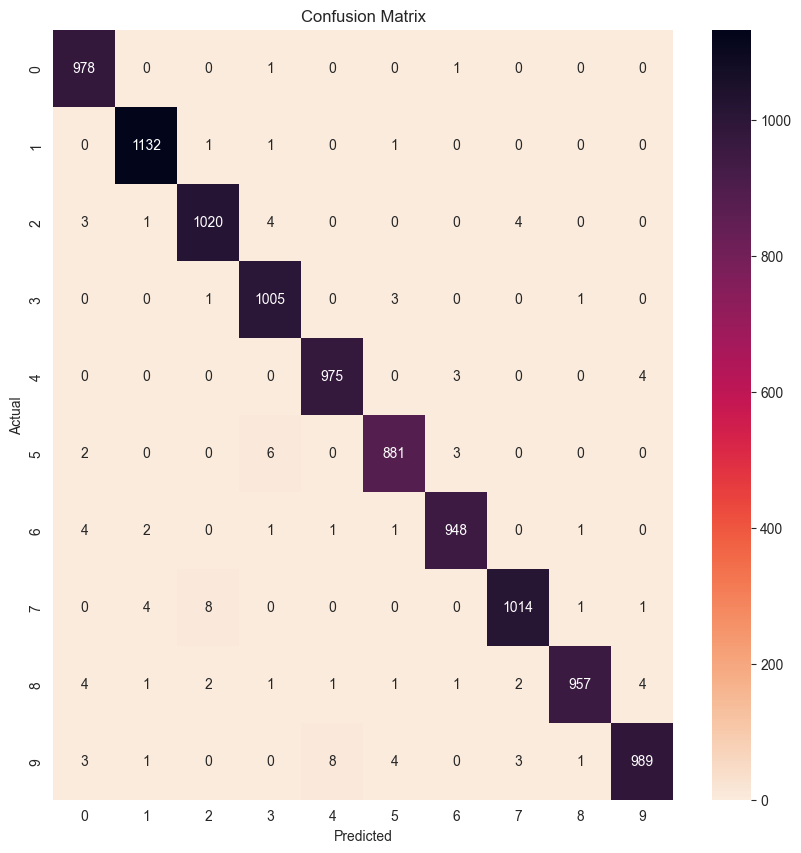

In [34]:
# Calcular la matriz de confusión
conf_mat = confusion_matrix(resultados["Test"],resultados["normal_cnn"])
# Visualiza la matriz de confusión usando Seaborn y Matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=[f'{i}' for i in range(10)],
                yticklabels=[f'{i}' for i in range(10)],
                cmap="rocket_r")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

podemos ver que no suele equivocarse en gran medida nuestro cnn ya que en la diagonal principal es donde estancayendo todas nuestras prediccion, esto es buenisimo.

In [35]:
def plot_multiclass_roc(y_test, y_pred, num_classes):
    # Binarizar las etiquetas en un formato one-hot
    y_test_binarized = label_binarize(y_test, classes=list(range(num_classes)))
    y_pred_binarized = label_binarize(y_pred, classes=list(range(num_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calcula la curva ROC y el área bajo la curva para cada clase
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Crea la figura de Plotly para la curva ROC
    fig = go.Figure()
    for i in range(num_classes):
        hover_text = f'Class {i} AUC = {roc_auc[i]:.2f}'
        fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', name=f'Class {i}',
                                 text=[hover_text] * len(fpr[i]), hoverinfo='text+x+y'))

    # Agregar línea de azar
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='navy', width=2, dash='dash'),
                             name='Chance', hoverinfo='none'))

    # Configuración del layout del gráfico
    fig.update_layout(
        title='Multiclass ROC Curve',
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        legend_title='Classes',
        xaxis=dict(scaleanchor="y", scaleratio=1),
        yaxis=dict(constrain='domain'),
        width=600,
        height=600
    )
    return fig

plot_multiclass_roc(resultados["Test"],resultados["normal_cnn"],10)

lo dicho anteriormente lo podemos validar con este grafico ya que vemos que el codo de todos los digitos esta muy cercanos a 1

### MODELO DECISION TREE Y RANDOM FOREST CON PCA 

#### Decision Tree

se entreno modelos con pipelines para asi poder utilizar el pca como preprocesamiento de nuestros datos con el objetivo de hacer una reduccion de dimensionalidad.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import requests
import pickle
import joblib

In [23]:
# Cargar el modelo desde el archivo pickle
def fetch_pkl_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Asegura que la respuesta sea exitosa
        with open("temp.pkl", "wb") as f:
            f.write(response.content)
        pipeline = joblib.load("temp.pkl")
        return pipeline
    except requests.RequestException as e:
        print(f"Error al realizar la solicitud HTTP: {e}")
    except Exception as e:
        print(f"Otro error: {e}")

    return None

pipeline_dt = fetch_pkl_from_url("https://github.com/vesgac/Visualizaci-n/raw/main/modelo_entrenado_dt.pkl")
pipeline_dt

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('clf', DecisionTreeClassifier())])

Text(0.5, 1.0, 'Confusion Matrix')

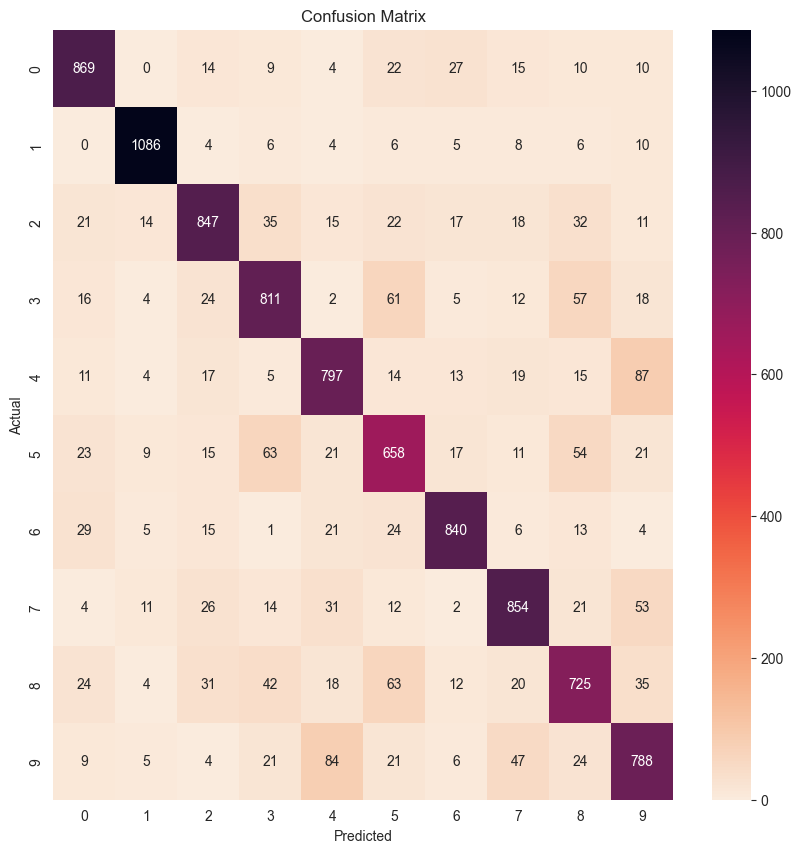

In [22]:
# Calcular la matriz de confusión
conf_mat = confusion_matrix(resultados["Test"],resultados["normal_dt"])
# Visualiza la matriz de confusión usando Seaborn y Matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=[f'{i}' for i in range(10)],
                yticklabels=[f'{i}' for i in range(10)],
                cmap="rocket_r")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

aqui podemos ver que en comparasion con el bcnn pues el modelo suele equivocarse mas, esto pues es de esperar ya que al utilizar redes neuronales y incluyendo la estadistica bayesiana, esperamos que los resultados sean mejores que modelos convencionales.

In [27]:
def plot_multiclass_roc(y_test, y_pred, num_classes):
    # Binarizar las etiquetas en un formato one-hot
    y_test_binarized = label_binarize(y_test, classes=list(range(num_classes)))
    y_pred_binarized = label_binarize(y_pred, classes=list(range(num_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calcula la curva ROC y el área bajo la curva para cada clase
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Crea la figura de Plotly para la curva ROC
    fig = go.Figure()
    for i in range(num_classes):
        hover_text = f'Class {i} AUC = {roc_auc[i]:.2f}'
        fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', name=f'Class {i}',
                                 text=[hover_text] * len(fpr[i]), hoverinfo='text+x+y'))

    # Agregar línea de azar
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='navy', width=2, dash='dash'),
                             name='Chance', hoverinfo='none'))

    # Configuración del layout del gráfico
    fig.update_layout(
        title='Multiclass ROC Curve',
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        legend_title='Classes',
        xaxis=dict(scaleanchor="y", scaleratio=1),
        yaxis=dict(constrain='domain'),
        width=600,
        height=600
    )
    return fig

plot_multiclass_roc(resultados["Test"],resultados["normal_dt"],10)

Aqui podemos ver que este modelo no es tan bueno para ciertos digitos como lo son el (5, 8) ya que son los que peor curva roc y AUC tienen, pues puede que estos sean muy complejos para el arbol de decision con esos parametros.

#### Random Forest

In [25]:
# Cargar el modelo desde el archivo pickle
def fetch_pkl_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Asegura que la respuesta sea exitosa
        with open("temp.pkl", "wb") as f:
            f.write(response.content)
        pipeline = joblib.load("temp.pkl")
        return pipeline
    except requests.RequestException as e:
        print(f"Error al realizar la solicitud HTTP: {e}")
    except Exception as e:
        print(f"Otro error: {e}")

    return None

pipeline_rf = fetch_pkl_from_url("https://github.com/vesgac/Visualizaci-n/raw/main/modelo_entrenado_rf_2.pkl")
pipeline_rf

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 RandomForestClassifier(max_depth=3, n_estimators=10,
                                        random_state=42))])

Text(0.5, 1.0, 'Confusion Matrix')

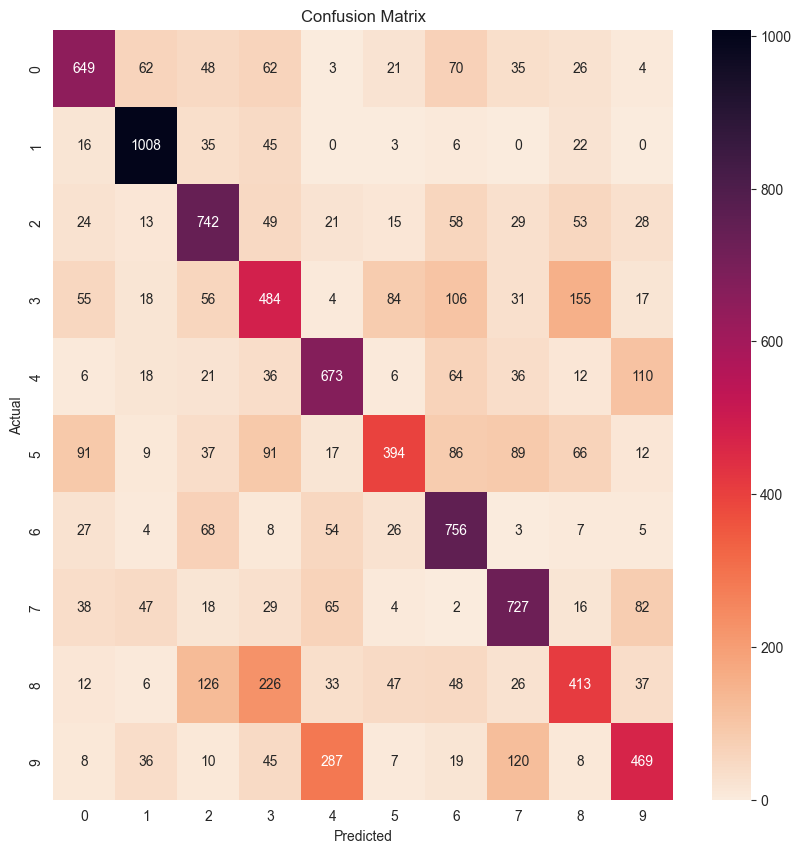

In [26]:
# Calcular la matriz de confusión
conf_mat = confusion_matrix(resultados["Test"],resultados["normal_rf"])
# Visualiza la matriz de confusión usando Seaborn y Matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=[f'{i}' for i in range(10)],
                yticklabels=[f'{i}' for i in range(10)],
                cmap="rocket_r")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

Aqui podemos ver que el random forest esta soliendo confundir el 4 con el 9 y el 8 con el 3, aunque no es descabellado que se pueda confundir los modelos por esto podemos ver que aun asi utilizando un modelo mas complejo que el decision tree como lo es random forest se sigue equivocando bastante.

In [28]:
def plot_multiclass_roc(y_test, y_pred, num_classes):
    # Binarizar las etiquetas en un formato one-hot
    y_test_binarized = label_binarize(y_test, classes=list(range(num_classes)))
    y_pred_binarized = label_binarize(y_pred, classes=list(range(num_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calcula la curva ROC y el área bajo la curva para cada clase
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Crea la figura de Plotly para la curva ROC
    fig = go.Figure()
    for i in range(num_classes):
        hover_text = f'Class {i} AUC = {roc_auc[i]:.2f}'
        fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', name=f'Class {i}',
                                 text=[hover_text] * len(fpr[i]), hoverinfo='text+x+y'))

    # Agregar línea de azar
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='navy', width=2, dash='dash'),
                             name='Chance', hoverinfo='none'))

    # Configuración del layout del gráfico
    fig.update_layout(
        title='Multiclass ROC Curve',
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        legend_title='Classes',
        xaxis=dict(scaleanchor="y", scaleratio=1),
        yaxis=dict(constrain='domain'),
        width=600,
        height=600
    )
    return fig

plot_multiclass_roc(resultados["Test"],resultados["normal_rf"],10)

por lo que podemos ver es que el modelo esta teniendo malos resultados y cae por mucho en ciertos digitos, puede ser porque no esta entendiendo, ni aprendiendo de nuestro conjunto de entrenamiento. 

### Comparacion todos los modelos

In [24]:
url4 = 'https://github.com/vesgac/Visualizaci-n/raw/main/metricas_normal.csv'
metricas = fetch_csv_from_url(url4)


def create_heatmap(df, index_col='Modelos'):
    # Asegurarse de que el DataFrame usa la columna 'Modelos' como índice
    if index_col in df.columns:
        df = df.set_index(index_col)

    # Preparar texto para hover con información de modelo, métrica y valor
    hover_text = [[f'Modelo: {y}<br>Métrica: {x}<br>Valor: {z:.3f}' 
                   for x, z in zip(df.columns, row)] for y, row in zip(df.index, df.values)]

    # Crear el heatmap
    fig = go.Figure(data=go.Heatmap(
        z=df.values,
        x=df.columns,
        y=df.index,
        colorscale='Rdbu',
        hoverongaps=False,
        text=hover_text,
        hoverinfo='text'
    ))

    # Actualizar el diseño del gráfico
    fig.update_layout(
        title='Comparación de Métricas por Modelo',
        xaxis_title='Métricas',
        yaxis_title='Modelos',
        xaxis={'side': 'top'},
        yaxis=dict(autorange='reversed'),
        width=800,
        height=600
    )

    return fig

create_heatmap(metricas)

aqui podemos ver que ambos modelos son buenisimos (esto puede ser por la naturaleza de los datos, es decir que es un dataset de entrenamiento por lo que las clases estan bien definidas) pero el BCNN tiene las metricas un poco bajas no obstante lo importante de las bayesianas es que podemos separar de las cuales el modelo no tiene seguridad, y asi mejorar un poco esa metrica.

## Prediccion y Explicabilidad

### Prediccion con monte carlo

In [18]:
import matplotlib.pyplot as plt

In [19]:
n_mc_run = 50
med_prob_thres = 0.35

y_pred_logits_list_bnn = [model_bcnn(X_test) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all_bnn = np.concatenate([tf.nn.softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list_bnn], axis=-1)
y_pred_bnn = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all_bnn]
y_pred_bnn = np.array(y_pred_bnn)

idx_valid = [any(y) for y in y_pred_bnn]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred_bnn]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (Global Accuracy):',
      sum(np.equal(np.argmax(y_test, axis=-1), np.argmax(y_pred_bnn, axis=-1))) / len(y_test))

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred_bnn[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred_bnn[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

Number of recognizable samples: 9976
Unrecognizable samples: [ 495  726 1549 1709 2414 3060 3727 3757 3853 4248 4265 4571 5887 6059
 6532 6572 6576 6945 8246 8408 9745 9879 9905 9982]
Test accuracy on MNIST (Global Accuracy): 0.9859
Test accuracy on MNIST (recognizable samples): 0.9880713712910987
Test accuracy on MNIST (unrecognizable samples): 0.08333333333333333


In [20]:
def plot_pred_hist(y_pred, n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=2, figsize=(25, 10)):
    bins = np.logspace(-n_bins, 0, n_bins+1)
    fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=figsize)
    for i in range(n_subplot_rows):
        for j in range(n_class // n_subplot_rows + 1):
            idx = i * (n_class // n_subplot_rows + 1) + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median probability: {:.2f}) ({})".format(str(idx),
                                                                               np.median(y_pred[idx]),
                                                                               str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    plt.show()

Valor verdadero de la muestra 0: 7


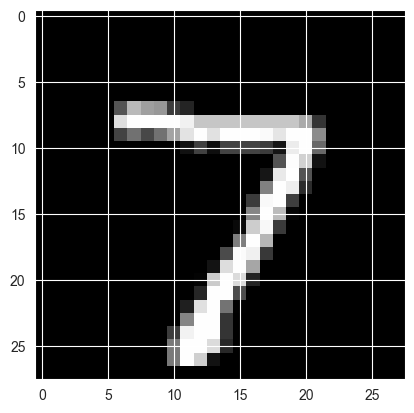

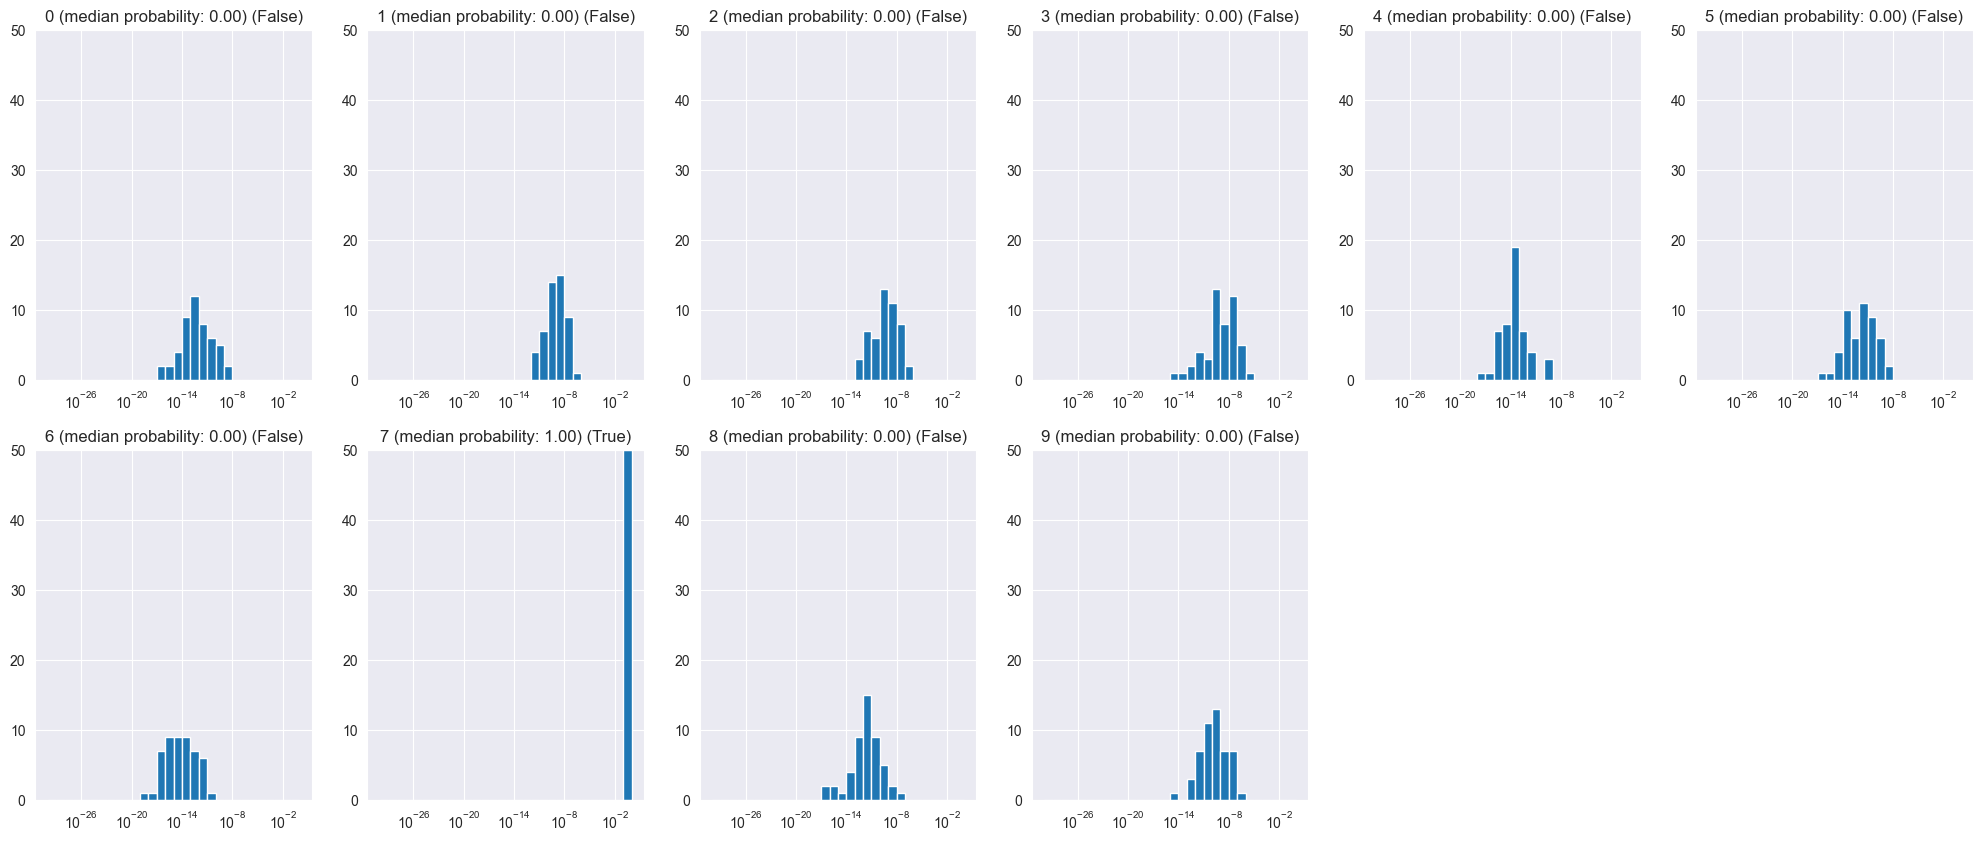

In [21]:
class_nmr = 10
plt.imshow(X_test[0, :, :], cmap='gist_gray')
print("Valor verdadero de la muestra {}: {}".format(0, np.argmax(y_test[0], axis=-1)))

plot_pred_hist(y_pred_prob_all_bnn[0], class_nmr, n_mc_run, med_prob_thres=med_prob_thres)

como podemos ver gracias a la simulación de montecarlo, cuales son la mediana de las probabilidades de caer en cierta clase de la imagen predicha, esto y como se evidencia en el grafico la clase 7 es la que tiene mayor probabilidades de ser esa clase por lo que modelo nos dice que hay confianza en esa predicción.

### GRAD CAM

vamos a utilizar grad cam para ver un poco como podemos explicar esa prediccion del modelo, ya que en la seccion anterior podemos ver que el modelo tiene una alta seguridad al predecir que esa imagen es 7, entonces lo que veremos con el grad cam va a ser cuales fueron los pixeles que aportaron a esa prediccion.

In [22]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
        # Convertir el heatmap y la imagen a punto flotante en el rango [0, 1]
        heatmap_float = heatmap.astype(np.float32) / 255.0
        image_float = image.astype(np.float32) / 255.0
    
        # Aplicar la superposición ponderada
        output = cv2.addWeighted(image_float, alpha, heatmap_float, 1 - alpha, 0)
    
        # Aplicar el mapa de color al heatmap
        heatmap_colored = cv2.applyColorMap((heatmap * 255).astype(np.uint8), colormap)
    
        # Devolver una tupla con el heatmap coloreado y la imagen superpuesta
        return heatmap_colored, output

In [23]:
def adjust_image_dimensions(image_np):
    if image_np.ndim == 2:  # si la imagen no tiene el canal de color
        image_np = np.expand_dims(image_np, axis=-1)

    # Añadir la dimensión del batch
    image_np = np.expand_dims(image_np, axis=0)

    # Asegurar que la imagen tenga el tipo de dato correcto
    image_np = tf.cast(image_np, tf.float32)
    
    return image_np

In [28]:
gradcam = GradCAM(model=model_bcnn, classIdx=np.argmax(y_pred_bnn[0]),layerName='conv2d_flipout_1')
        
# Generar el heatmap de GradCAM
adjusted_image = adjust_image_dimensions(X_test[0, :, :])
heatmap = gradcam.compute_heatmap(adjusted_image)

# Normalizar el heatmap al rango [0, 1]
heatmap_normalized = heatmap.astype(np.float32) / 255.0

# Sobrelayar el heatmap en la imagen original
heatmap_overlay, output_image = gradcam.overlay_heatmap(heatmap_normalized, X_test[0, :, :])


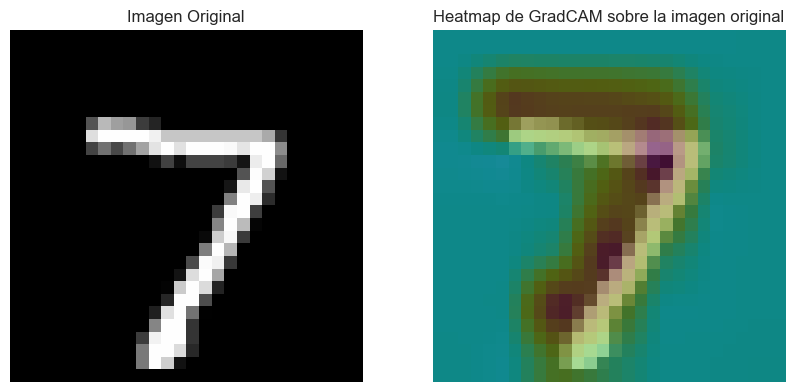

In [27]:
import matplotlib.pyplot as plt
# Mostrar la imagen original y el heatmap superpuesto
plt.figure(figsize=(10, 5))

# Mostrar la imagen original
plt.subplot(1, 2, 1)
plt.imshow(X_test[0, :, :], cmap='gray')
plt.title('Imagen Original')
plt.axis('off')

# Mostrar el heatmap superpuesto
plt.subplot(1, 2, 2)
plt.imshow(X_test[0, :, :], cmap='gray')
plt.imshow(heatmap_overlay, alpha=0.6)
plt.title('Heatmap de GradCAM sobre la imagen original')
plt.axis('off')

plt.show()

aqui con este grafico podemos ver cuales fueron los pixeles que mas aportaron a la prediccion de nuestro modelo y como podemos ver sigue con el mismo reccorrido que tiene la forma del 7, es decir esa forma en la imagen es la que hizo que la BCNN predijera que es un 7

In [33]:
def load_bcnn_model_final(url):
    def load_model_from_github(url):
        response = requests.get(url)
        response.raise_for_status()  # Asegúrate de que la solicitud fue exitosa

        # Guardar en un archivo temporal
        with tempfile.NamedTemporaryFile(delete=False, suffix='.h5') as tmp:
            tmp.write(response.content)
            tmp.flush()  # Asegúrate de que todo el contenido se escriba en el archivo
            model = load_model(tmp.name)  # Cargar el modelo desde el archivo temporal

            return model

    def neg_log_likelihood_with_logits(y_true, y_pred):
        y_pred_dist = tfp.distributions.Categorical(logits=y_pred)
        return -tf.reduce_mean(y_pred_dist.log_prob(tf.argmax(y_true, axis=-1)))

    def add_kl_weight(layer, train_size, w_value=1.0):
        w = layer.add_weight(name=layer.name+'/kl_loss_weight', shape=(),
                             initializer=tf.initializers.constant(w_value), trainable=False)
        layer.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
        return layer

    def get_kernel_divergence_fn(train_size, w=1.0):

        def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
            kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
            return w * kernel_divergence
        return kernel_divergence_fn

    def build_bayesian_bcnn_model(input_shape, train_size, n_class):
        model_in = Input(shape=input_shape)
        conv_1 = Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
        conv_1 = add_kl_weight(conv_1, train_size)
        x = conv_1(model_in)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        conv_2 = Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
        conv_2 = add_kl_weight(conv_2, train_size)
        x = conv_2(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Flatten()(x)
        dense_1 = DenseFlipout(512, activation='relu',
                           kernel_divergence_fn=None)
        dense_1 = add_kl_weight(dense_1, train_size)
        x = dense_1(x)
        dense_2 = DenseFlipout(n_class, activation=None,
                           kernel_divergence_fn=None)
        dense_2 = add_kl_weight(dense_2, train_size)
        model_out = dense_2(x)  # logits
        model = Model(model_in, model_out)
        return model

    # Descargar el archivo de pesos
    response = requests.get(url)

    # Verificar si la descarga fue exitosa
    if response.status_code == 200:
        # Guardar el contenido en un archivo local
        with open('pesos_bcnn_weights.h5', 'wb') as f:
            f.write(response.content)
        # Cargar el modelo bcnn_model_mnist con sus pesos
        model_bcnn = build_bayesian_bcnn_model((28, 28, 1), 60000, 10)
        model_bcnn.load_weights('pesos_bcnn_weights.h5')
        return model_bcnn
    else:
        print("Error al descargar los pesos del modelo.")
        return None
    
    
bcnn_final_finalisimo= load_bcnn_model_final('https://github.com/vesgac/Visualizaci-n/raw/main/pesos_bcnn_weights.h5')





c:\miniconda\envs\imagenes_venv\lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning:

`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.

c:\miniconda\envs\imagenes_venv\lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning:

`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.



In [ ]:
y_pred_logits_list_bnn_finalfinalisimo = [bcnn_final_finalisimo(X_test) for _ in range(n_mc_run)]